In [1]:
import numpy as np
from feos_pcsaft.si import *
from feos_pcsaft import *
from feos_pcsaft.eos import *
from feos_pcsaft.eos import State as StateEoS
from feos_pcsaft.eos import PhaseEquilibrium as PhaseEquilibriumEoS
from feos_pcsaft.dft import *
# from feos_pcsaft.dft import *
# from feos_pcsaft.feos_pcsaft import *
import glob
#import scipy as sp
import numpy as np
import matplotlib.pyplot as plt
feos_pcsaft.__file__

'/usr/ITT/bursik/promotion/entropy_scaling_AS/entropyScaling/venv_entropyscaling/lib/python3.8/site-packages/feos_pcsaft/feos_pcsaft.abi3.so'

In [2]:
components = ['propane']#, 'butane']#, 'pentane']
composition = np.array([0.5, 0.5]) *MOL
temperature = 210.15* KELVIN
pressure = 1 * BAR

In [3]:
params = PcSaftParameters.from_json(components, '../parameters/propane_with_entropy_scaling.json')
eos = PcSaft(params)

In [4]:
if len(components) == 1:
    t_crit = StateEoS.critical_point_pure(eos)[0].temperature
    vleEoS = PhaseEquilibriumEoS.pure_t(eos, temperature)
else:
    t_crit = StateEoS.critical_point(eos, composition).temperature
    vleEoS = PhaseEquilibriumEoS.bubble_point_tx(eos, temperature, composition/MOL)
vleEoS

||temperature|density|
|-|-|-|
|phase 1|210.15000 K|21.11622  mol/m³|
|phase 2|210.15000 K|13.64952 kmol/m³|


In [5]:
print(vleEoS.liquid.viscosity())
print(vleEoS.vapor.viscosity())


249.07038554129383 µPas
5.61065359133366 µPas


In [6]:
params = PcSaftParameters.from_json(components, '../parameters/propane_with_entropy_scaling.json')
func = PcSaftFunctional(params)
func_hs = (params)
params

|component|molarweight|$m$|$\sigma$|$\varepsilon$|$\mu$|$Q$|$\kappa_{AB}$|$\varepsilon_{AB}$|$N_A$|$N_B$|
|-|-|-|-|-|-|-|-|-|-|-|
|propane|44.0962|2.0018290000000003|3.618353|208.1101|0|0|0|0|1|1|

In [7]:
if len(components) == 1:
    t_crit = State.critical_point_pure(func)[0].temperature
    vle = PhaseEquilibrium.pure_t(func, temperature)
else:
    t_crit = State.critical_point(func, composition).temperature
    vle = PhaseEquilibrium.bubble_point_tx(func, temperature, composition/MOL)
vle

||temperature|density|
|-|-|-|
|phase 1|210.15000 K|21.11622  mol/m³|
|phase 2|210.15000 K|13.64952 kmol/m³|


In [8]:
# PLANAR INTERFACE
interface = PlanarInterface.from_tanh(vle, 1024, 80 * ANGSTROM, t_crit)

In [9]:
# PORE 1D
potential  = ExternalPotential.LJ93(2.5, 40.0, 0.08)
interface = Pore1D(func, Geometry.Cartesian, 50*ANGSTROM, potential, 512).initialize(vle.liquid)

In [10]:
solver = DFTSolver(output=False).picard_iteration(tol=1.0e-8, beta=0.01, max_iter=30, log=False).anderson_mixing(tol=1.0e-9,mmax=10)#
density_init = interface.density
interface.solve(solver, debug=False)   

In [11]:
# print(interface.surface_tension)

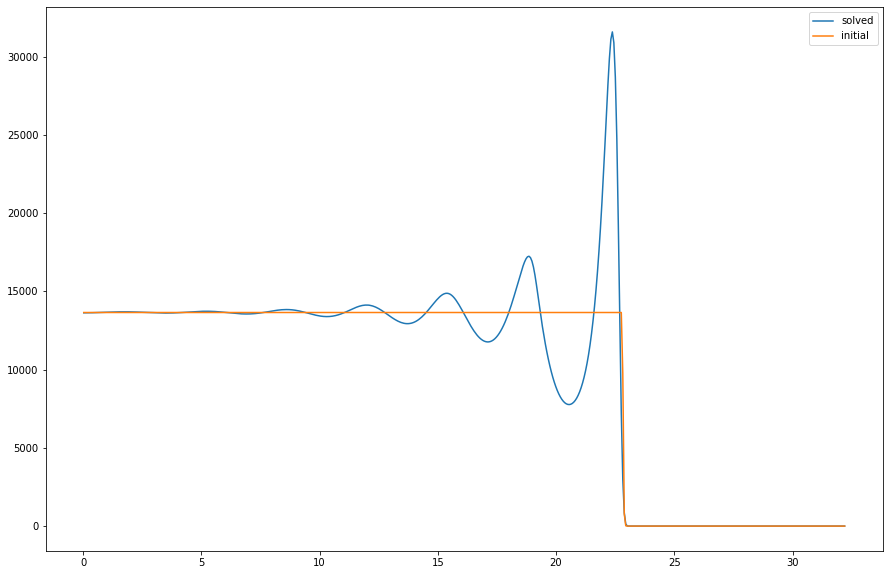

In [34]:
plt.figure(figsize=[15,10])
plt.plot(interface.z/ANGSTROM, (interface.density/MOL*METER**3)[0], label='solved')
plt.plot(interface.z/ANGSTROM, (density_init/MOL*METER**3)[0], label='initial')
# plt.plot(interface.z/ANGSTROM, (interface.weighted_densities[0])[0,:], label='wd')
plt.legend()

In [23]:
print(interface.viscosity_profile[0])
print(interface.viscosity_profile[-1])

0 in wd_entropy
250.4190649016592 µPas
1 in wd_entropy
2 in wd_entropy
3 in wd_entropy
0 in edc
1 in edc
2 in edc
3 in edc
0 in entr_contrib
1 in entr_contrib
2 in entr_contrib
3 in entr_contrib
0 in wd_entropy
1 in wd_entropy
2 in wd_entropy
3 in wd_entropy
0 in edc
1 in edc
2 in edc
3 in edc
0 in entr_contrib
1 in entr_contrib
2 in entr_contrib
3 in entr_contrib
5.556669568741585 µPas


0 in wd_entropy
1 in wd_entropy
2 in wd_entropy
3 in wd_entropy
0 in edc
1 in edc
2 in edc
3 in edc
0 in entr_contrib
1 in entr_contrib
2 in entr_contrib
3 in entr_contrib


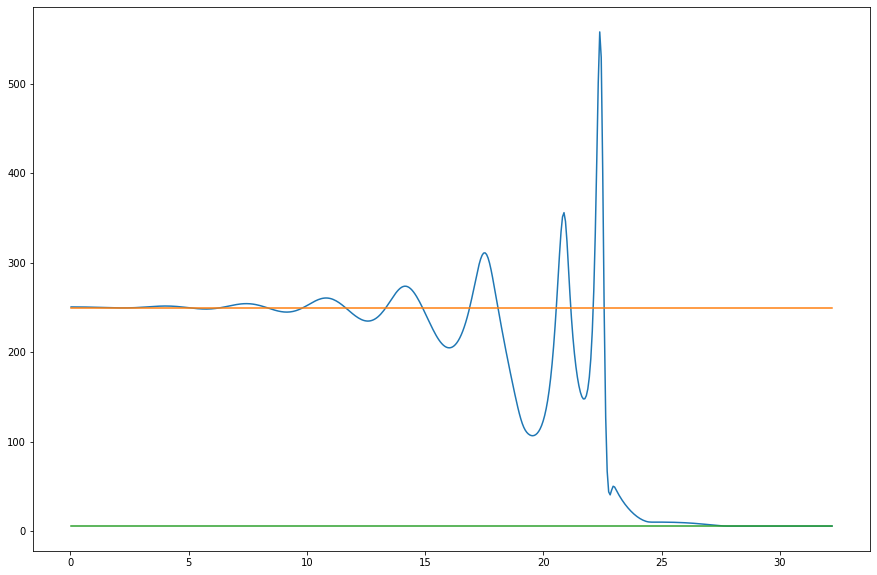

In [24]:
plt.figure(figsize=[15,10])

plt.plot(interface.z/ANGSTROM, interface.viscosity_profile/MICRO/PASCAL/SECOND)
plt.plot([interface.z[0]/ANGSTROM, interface.z[-1]/ANGSTROM], [vleEoS.liquid.viscosity()/MICRO/PASCAL/SECOND, vleEoS.liquid.viscosity()/MICRO/PASCAL/SECOND])
plt.plot([interface.z[0]/ANGSTROM, interface.z[-1]/ANGSTROM], [vleEoS.vapor.viscosity()/MICRO/PASCAL/SECOND, vleEoS.vapor.viscosity()/MICRO/PASCAL/SECOND])


(1, 512)
(1, 512)


Text(0, 0.5, '$\\rho$')

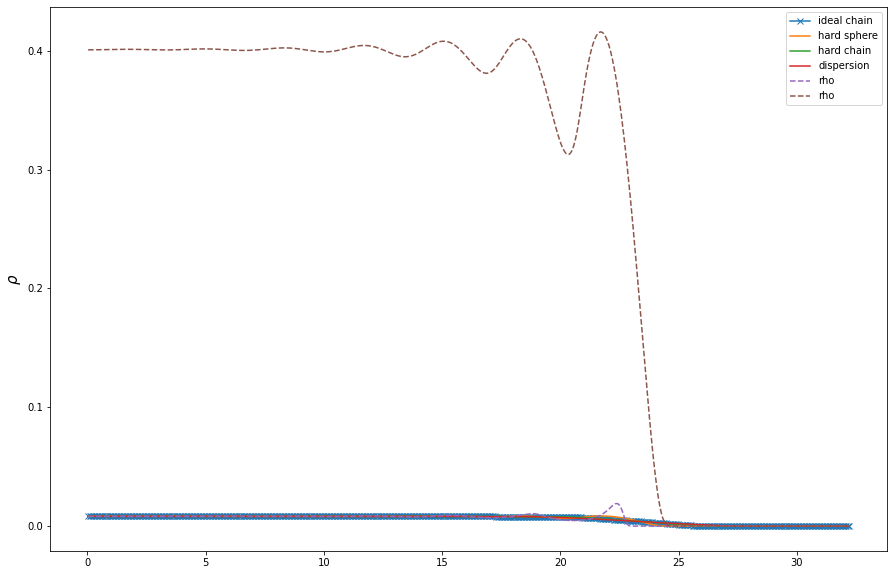

In [26]:
plt.figure(figsize=[15,10])
    
# for filename in glob.glob('*wd_entropy.npy'):
#     data = np.load(filename)    
#     print(f'data shape = {data.shape}')
#     for j in range(data.shape[0]):
#         plt.plot(interface.z / ANGSTROM, (data)[j,:], label=f'wd rho {j}')#, marker = 'x')

data = np.load('0_wd_entropy.npy')
plt.plot(interface.z / ANGSTROM, (data)[0,:], label=f'ideal chain', marker = 'x')
print(data.shape)

data_hs = np.load('1_wd_entropy.npy')
print(data_hs.shape)
plt.plot(interface.z / ANGSTROM, (data_hs)[0,:], label=f'hard sphere')#, marker = 'x')

data = np.load('2_wd_entropy.npy')
plt.plot(interface.z / ANGSTROM, (data)[0,:], label=f'hard chain')#, marker = 'x')

data = np.load('3_wd_entropy.npy')
plt.plot(interface.z / ANGSTROM, (data)[0,:], label=f'dispersion')#, marker = 'x')

plt.plot(interface.z/ANGSTROM, (interface.density*NAV*ANGSTROM**3)[0,:], label='rho', linestyle='--')

plt.plot(interface.z/ANGSTROM, (interface.weighted_densities[0])[1,:], label='rho', linestyle='--')
plt.legend()
plt.ylabel(r'$\rho$', fontsize=15)

Text(0, 0.5, '$s^{res}_{contrib}(r)$')

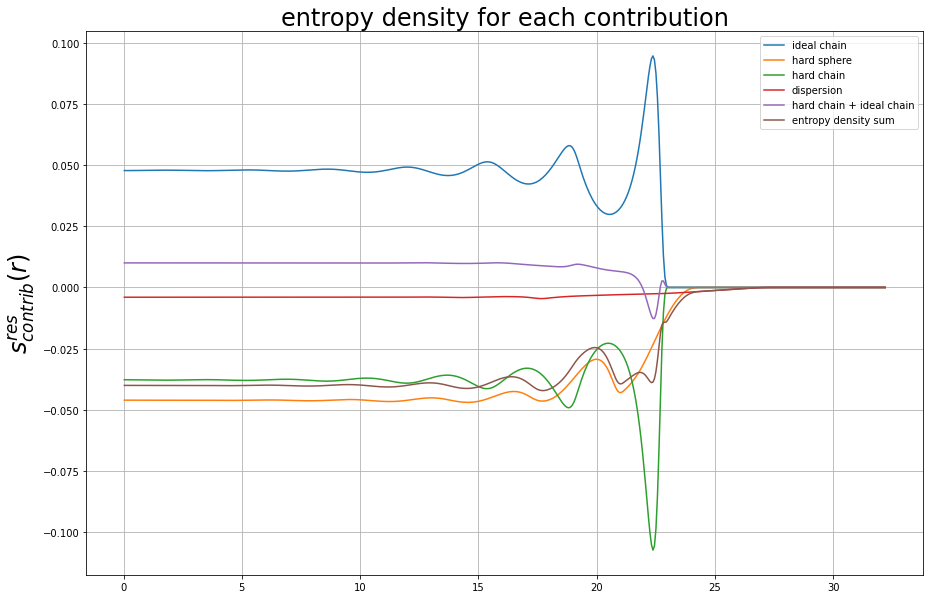

In [16]:
plt.figure(figsize=[15,10])
entropy_density = np.zeros((interface.z/ANGSTROM).shape[0])

# for filename in glob.glob('*edc.npy'):
#     data = np.load(filename)    
#     print(f'data shape = {data.shape}')
    
#     plt.plot(interface.z / ANGSTROM, (data), label=f'entropy_density_contrib')#, marker = 'x')
#     entropy_density = entropy_density + data

data_ic = np.load('0_edc.npy')
plt.plot(interface.z / ANGSTROM, (data_ic), label=f'ideal chain')#, marker = 'x')
entropy_density = entropy_density + data_ic


data_hs = np.load('1_edc.npy')
entropy_density = entropy_density + data_hs
plt.plot(interface.z / ANGSTROM, (data_hs), label=f'hard sphere')#, marker = 'x')

data_hc = np.load('2_edc.npy')
entropy_density = entropy_density + data_hc
plt.plot(interface.z / ANGSTROM, (data_hc), label=f'hard chain')#, marker = 'x')

data_disp = np.load('3_edc.npy')
entropy_density = entropy_density + data_disp
plt.plot(interface.z / ANGSTROM, (data_disp), label=f'dispersion')#, marker = 'x')

plt.plot(interface.z / ANGSTROM, (data_hc) + (data_ic), label=f'hard chain + ideal chain')#, marker = 'x')

# plt.plot(interface.z/ANGSTROM, entropy_density, label='entropy density sum', marker='o')
# plt.plot(interface.z/ANGSTROM, interface.entropy_density(Contributions.Residual)/PASCAL/SECOND, label='entropy sum')
plt.plot(interface.z/ANGSTROM, interface.entropy_density(Contributions.Residual)/RGAS*NAV*ANGSTROM**3, label='entropy density sum')

#plt.xlim([20, 28])
#plt.ylim([-0.01, 0.01])
plt.legend()
plt.grid()
plt.title('entropy density for each contribution', fontsize=24)
plt.ylabel(r'$s^{res}_{contrib}(r)$', fontsize=24)

(-20.0, 20.0)

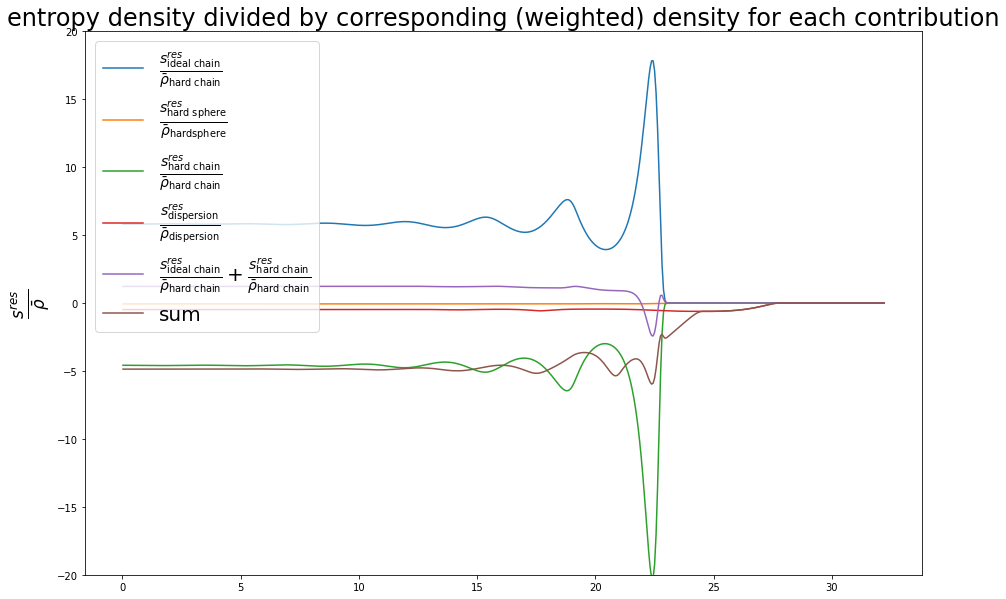

In [17]:
plt.figure(figsize=[15,10])
entropy = np.zeros((interface.z/ANGSTROM).shape[0])


data_ic = np.load('0_edc.npy')
data_wd_ic = np.load('0_wd_entropy.npy')
plt.plot(interface.z / ANGSTROM, data_ic/data_wd_ic[0,:], label=r'$\frac{s^{res}_{\mathrm{ideal\ chain}}}{\bar{\rho}_{\mathrm{hard\ chain}}}$')#, marker = 'x')
entropy = entropy +data_ic/data_wd_ic[0,:]

data_hs = np.load('1_edc.npy')
data_wd_hs = np.load('1_wd_entropy.npy')
entropy = entropy + (data_hs)/data_wd_hs[0,:]
plt.plot(interface.z / ANGSTROM, (data_hs)/(interface.weighted_densities[0])[0,:], label=r'$\frac{s^{res}_{\mathrm{hard\ sphere}}}{\bar{\rho}_{\mathrm{hard sphere}}}$')#, marker = 'x')
# plt.plot(interface.z / ANGSTROM, (data_hs)/data_wd_hs[0,:], label=r'$\frac{s^{res}_{\mathrm{hard\ sphere}}}{\bar{\rho}_{\mathrm{hard sphere}}}$')#, marker = 'x')

data_hc = np.load('2_edc.npy')
data_wd_hc = np.load('2_wd_entropy.npy')
entropy = entropy + (data_hc)/data_wd_hc[0,:]
plt.plot(interface.z / ANGSTROM, (data_hc)/data_wd_hc[0,:], label=r'$\frac{s^{res}_{\mathrm{hard\ chain}}}{\bar{\rho}_{\mathrm{hard\ chain}}}$')#, marker = 'x')

data_disp = np.load('3_edc.npy')
data_wd_disp = np.load('3_wd_entropy.npy')
entropy = entropy + (data_disp)/data_wd_disp[0,:]
plt.plot(interface.z / ANGSTROM, (data_disp)/data_wd_disp[0,:], label=r'$\frac{s^{res}_{\mathrm{dispersion}}}{\bar{\rho}_{\mathrm{dispersion}}}$')#, marker = 'x')

plt.plot(interface.z / ANGSTROM, data_ic/data_wd_ic[0,:]+(data_hc)/data_wd_hc[0,:], label=r'$\frac{s^{res}_{\mathrm{ideal\ chain}}}{\bar{\rho}_{\mathrm{hard\ chain}}} +\frac{s^{res}_{\mathrm{hard\ chain}}}{\bar{\rho}_{\mathrm{hard\ chain}}}$')#, marker = 'x')

plt.plot(interface.z / ANGSTROM, entropy, label=f'sum')#, marker = 'x')

#(interface.density*NAV*ANGSTROM**3)[0,:]


# for filename in glob.glob('*entr_contrib.npy'):
#     data = np.load(filename)    
#     plt.plot(interface.z / ANGSTROM, (data), label=f'entropy_contrib (from entropy scaling rust)')#, marker = 'x')
#     entropy = entropy + data
# plt.plot(interface.z/ANGSTROM, entropy, label='entropy sum (from entropy scaling rust)')
# # plt.plot(interface.z/ANGSTROM, interface.entropy_density(Contributions.Residual)/(((interface.density*NAV*ANGSTROM**3)[0,:])/NAV/ANGSTROM**3)/RGAS, label='entropy from regular density')

# entropy_notebook = np.zeros((interface.z/ANGSTROM).shape[0])

# for (filename_edc, filename_wd) in zip(glob.glob('*edc.npy'), glob.glob('*wd_entropy.npy')):
#     data_edc = np.load(filename_edc)   
#     data_wd = np.load(filename_wd)[0,:]   
    
#     plt.plot(interface.z / ANGSTROM, (data_edc)/data_wd, label=f'entropy_contrib (from notebook)', linestyle='--')#, marker = 'x')
#     entropy_notebook = entropy_notebook + data_edc/data_wd
# plt.plot(interface.z/ANGSTROM, entropy_notebook, label='entropy sum (from notebook)', linestyle='--')

# entropy_localrho = np.zeros((interface.z/ANGSTROM).shape[0])

# for filename in glob.glob('*_edc.npy'):
#     data = np.load(filename)    
#     plt.plot(interface.z / ANGSTROM, (data)/((interface.density*NAV*ANGSTROM**3)[0,:]), 'k--' ,label=f'entropy_contrib (from local density)')#, marker = 'x')
#     entropy_localrho = entropy_localrho + (data)/((interface.density*NAV*ANGSTROM**3)[0,:])
# plt.plot(interface.z/ANGSTROM, entropy_localrho, 'k--', label='entropy sum (from local density)')

# plt.plot(interface.z/ANGSTROM, interface.entropy_density(Contributions.Residual)/(((interface.density*NAV*ANGSTROM**3)[0,:])/NAV/ANGSTROM**3)/RGAS,label='entropy from regular density')

# plt.plot(interface.z/ANGSTROM, (interface.density*NAV*ANGSTROM**3)[0,:], label='rho')
plt.legend(fontsize=20)
plt.title('entropy density divided by corresponding (weighted) density for each contribution', fontsize=24)
plt.ylabel(r'$\frac{s^{res}}{\bar{\rho}}$', fontsize=24)
plt.ylim([-20,20])

In [18]:
interface.entropy_density(Contributions.Residual)#/#/KILOGRAM*ANGSTROM*KELVIN*SECOND**2

[-552282.8031080558, -552287.1213699055, -552295.6659773076, -552308.2546932616, -552324.6181627464, ..., -0.00000000000015504710504940104, -0.00000000000015491216647639597, -0.00000000000015481437805220278, -0.00000000000015475550770896348, -0.00000000000015474465048289573] m^-1 kg s^-2 K^-1

In [95]:
interface.entropy_density(Contributions.Residual)/((interface.density/MOL*METER**3)[0,:]*MOL/METER**3)

[-25.135041716617977, -25.13504145511071, -25.135040931942292, -25.13504014680662, -25.135039099243787, ..., -1.0996289472213965, -1.099628948967484, -1.0996289502734893, -1.099628951141789, -1.0996289515741486] J/mol/K

In [43]:
interface.entropy_density(Contributions.Residual)/(((interface.density*NAV*ANGSTROM**3)[0,:])/NAV/ANGSTROM**3)/RGAS

array([-3.02305066, -3.02305063, -3.02305057, ..., -0.13225496,
       -0.13225496, -0.13225496])

In [101]:
entropy

array([-2.6882359 , -2.68823588, -2.68823584, ..., -0.0668435 ,
       -0.06684351, -0.06684351])